In [2]:
import json
from urllib.request import urlopen
import urllib
import pandas as pd
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE 


In [3]:
os.chdir("..") 

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.prompt { font-size: 08px !important; }</style>"))
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [5]:
seed = 1111

In [6]:
data_path = "data/"

In [7]:
X_train = pd.read_csv(data_path + 'train.csv', sep='\t', encoding='utf-8', )  
X_train.head()

,id,site_id,title,price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,accepts_mercadopago,attributes,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,seller.id,seller.registration_date,seller.car_dealer,seller.real_estate_agency,seller.tags,seller.seller_reputation.transactions.total,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.period,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.ratings.neutral,seller.seller_reputation.transactions.completed,seller.seller_reputation.power_seller_status,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.claims.period,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.delayed_handling_time.period,seller.seller_reputation.metrics.sales.period,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.seller_reputation.metrics.cancellations.period,seller.seller_reputation.level_id,prices.prices,address.state_id,address.state_name,address.city_id,address.city_name,shipping.free_shipping,shipping.mode,shipping.tags,shipping.logistic_type,shipping.store_pick_up,seller_address.id,seller_address.country.id,seller_address.country.name,seller_address.state.id,seller_address.state.name,seller_address.city.id,seller_address.city.name,differential_pricing.id,seller.seller_reputation.metrics.claims.excluded.real_rate,seller.seller_reputation.metrics.claims.excluded.real_value,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_rate,seller.seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller.seller_reputation.metrics.cancellations.excluded.real_rate,seller.seller_reputation.metrics.cancellations.excluded.real_value,seller.seller_reputation.protection_end_date,seller.seller_reputation.real_level,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name,seller.eshop.eshop_rubro.category_id,root_category_id,root_category_name,seller_contact.contact,seller_contact.phone,seller_contact.email,seller_contact.webpage,location.neighborhood.id,location.neighborhood.name,location.city.id,location.city.name,location.state.id,location.state.name,location.country.id,location.country.name,sale_terms,discount,category_name,categories_from_root
0,MLA861624069,MLA,Rociador Pulverizador Difusor Tattoo Tipo Box ...,540.00,ARS,1,25,buy_it_now,gold_special,2040-06-06T04:00:00.000Z,new,True,"[{'source': 2860837171021627, 'id': 'BRAND', '...",NaN,MLA412100,NaN,MLA-UNCLASSIFIED_PRODUCTS,NaN,"['good_quality_picture', 'good_quality_thumbna...",NaN,182155865,2015-04-28T08:27:58.000-04:00,False,False,"['normal', 'user_info_verified', 'credits_acti...",9826.0,545.0,historic,0.04,0.94,0.02,9281.0,platinum,0.0044,8.0,60 days,0.1482,254.0,60 days,60 days,1733.0,0.0055,10.0,60 days,5_green,"[{'id': '2', 'type': 'standard', 'conditions':...",AR-S,Santa Fe,NaN,Santa Fe,False,me2,[],drop_off,False,NaN,AR,Argentina,AR-S,Santa Fe,NaN,Santa Fe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MLA1953,Otras categorías,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Otros,"['Otras categorías', 'Insumos para Tatuajes', ..."
1,MLA883251724,MLA,Kn#95 Con Certificado Barbijo X10 Unidades - 3...,919.00,ARS,5000,500,buy_it_now,gold_pro,2041-01-30T18:10:06.000Z,new,True,"[{'attribute_group_id': 'OTHERS', 'name': 'Mar...",NaN,MLA69570,NaN,MLA-SURGICAL_MASKS,NaN,"['good_quality_picture', 'good_quality_thumbna...",NaN,638528199,2020-09-03T20:42:37.000-04:00,False,False,"['normal', 'user_info_verified', 'eshop', 'msh...",7591.0,585.0,historic,0.08,0.88,0.04,7006.0,platinum,0.0148,76.0,60 days,0.1279,539.0,60 days

In [8]:
X_train.shape

(23203, 92)

In [9]:
X_train.dtypes

id                                                                             object
site_id                                                                        object
title                                                                          object
price                                                                         float64
currency_id                                                                    object
available_quantity                                                              int64
sold_quantity                                                                   int64
buying_mode                                                                    object
listing_type_id                                                                object
stop_time                                                                      object
condition                                                                      object
accepts_mercadopago                                   

In [10]:
aux = X_train.copy()

In [13]:
X_train.available_quantity.value_counts().sort_index()

1        13364
2            4
3            1
4            4
5            2
6            2
7            4
8            1
10           2
11           1
13           1
14           2
21           1
24           3
26           2
29           1
34           1
36           1
39           3
44           1
45           1
50        2634
54           1
62           1
65           2
71           1
92           2
99           2
100       1099
135          1
146          1
150        734
157          1
166          1
184          1
189          1
200        448
211          1
214          1
249          1
250       1560
341          1
345          1
348          1
496          1
500       2395
568          1
707          1
978          2
999          1
1500         1
1711         2
1833         1
1981         1
1984         1
2386         1
3447         1
4352         1
5000       680
7893         1
50000      214
Name: available_quantity, dtype: int64

## Target

In [11]:
X_train.sold_quantity.value_counts().sort_index()

0        2338
1         236
2         178
3         169
4         167
5        1757
11          1
13          1
14          2
16          2
22          2
24          1
25       1326
27          1
28          1
30          1
31          2
33          1
38          1
40          1
41          1
50       2081
56          1
57          1
66          1
68          1
72          1
83          2
84          1
88          1
100      1590
109         1
110         1
111         1
135         1
146         1
150      1350
164         2
198         1
200      1094
213         2
222         1
231         1
241         1
250      3533
255         1
265         1
269         1
316         1
401         1
456         1
500      6788
524         1
526         1
533         1
541         1
555         2
564         1
566         1
675         1
987         1
1034        1
1707        1
1928        1
2127        1
2215        1
2266        2
2436        1
2914        1
4911        1
5000      518
5308  

<p style="color:red; font-weight: bold">Hay valores que no tienen el value esperado (que representa cada categoria) asi que trabajamos eso. Además vamos a intentar probar unificar las categorias iniciales, considerando este tipo de decisiones, en caso de quen hagan que el modelo de mejor, deben consultarse siempre con el negocio </p>

In [12]:
bins = [0, 5, 25, 50, 100, 150, 200, 250, 500, 5000, 50000, 500000]

**Modification: 1-4 unified in one bin**

In [10]:
labels = [
    0, 5, 25, 50, 100, 150, 200, 250, 500, 5000, 50000,
]

In [26]:
X_train["sold_quantity_q"] = pd.cut(X_train['sold_quantity'], bins=bins, right=False,)  # labels=labels

Parentheses represent solutions greater or less than the number, and brackets represent solutions that are greater than or equal to or less than or equal to the number.

Starts with ...
- parenthesis: g

Ends with ...
- brackets: leq

In [27]:
X_train[[
    "sold_quantity",
    "sold_quantity_q",
]].head(20)

,sold_quantity,sold_quantity_q
0,25,"[25, 50)"
1,500,"[500, 5000)"
2,500,"[500, 5000)"
3,500,"[500, 5000)"
4,500,"[500, 5000)"
5,200,"[200, 250)"
6,250,"[250, 500)"
7,5000,"[5000, 50000)"
8,500,"[500, 5000)"
9,5000,"[5000, 50000)"


Probamos para algun valor en particular

In [28]:
X_train[[
    "sold_quantity",
    "sold_quantity_q",
]][X_train.sold_quantity==5]

,sold_quantity,sold_quantity_q
40,5,"[5, 25)"
47,5,"[5, 25)"
57,5,"[5, 25)"
84,5,"[5, 25)"
85,5,"[5, 25)"
...,...,...
23118,5,"[5, 25)"
23142,5,"[5, 25)"
23159,5,"[5, 25)"
23161,5,"[5, 25)"


In [29]:
X_train.sold_quantity_q.value_counts().sort_index()

[0, 5)             3088
[5, 25)            1766
[25, 50)           1335
[50, 100)          2090
[100, 150)         1595
[150, 200)         1353
[200, 250)         1099
[250, 500)         3539
[500, 5000)        6808
[5000, 50000)       524
[50000, 500000)       6
Name: sold_quantity_q, dtype: int64

<AxesSubplot:>

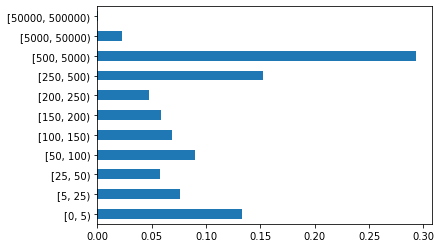

In [30]:
X_train.sold_quantity_q.value_counts(normalize=True).sort_index().plot.barh()

## corrMatrix - post pipeline

selected_columns = [
    
]

corrMatrix = df[selected_columns].corr()
corrMatrix

sn.heatmap(corrMatrix, annot=True)
plt.show()

## LabelEncoder

In [35]:
y = X_train.sold_quantity_q

enc = LabelEncoder()
enc.fit(y)
y_transformed = enc.transform(y)

<AxesSubplot:>

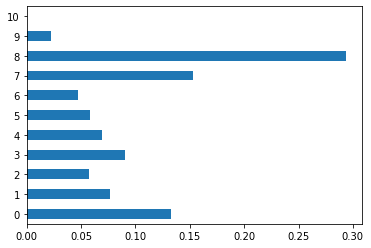

In [46]:
pd.Series(y_transformed).value_counts(normalize=True).sort_index().plot.barh()

In [41]:
dic = pd.Series(y_transformed).value_counts().sort_index().to_dict()
dic

{0: 3088,
 1: 1766,
 2: 1335,
 3: 2090,
 4: 1595,
 5: 1353,
 6: 1099,
 7: 3539,
 8: 6808,
 9: 524,
 10: 6}

## SMOTE

In [48]:
threshold = 3000
prop = 1.5

In [51]:
smote_sampling_strategy = {key: int(value*prop) if value < threshold else value for key, value in dic.items()}
smote_sampling_strategy

{0: 3088,
 1: 2649,
 2: 2002,
 3: 3135,
 4: 2392,
 5: 2029,
 6: 1648,
 7: 3539,
 8: 6808,
 9: 786,
 10: 9}

## IDs and target

In [ ]:
X_train = X_train.drop(['sold_quantity_q'], axis= 1)

In [ ]:
id_cols = [
    
]

In [ ]:
id_train = X_train[id_cols].copy()
X_train = X_train.drop(id_cols, axis= 1)

## Columns

In [ ]:
cols_preproc = X_train.columns

In [84]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.to_list()
# numeric_features

['price',
 'available_quantity',
 'sold_quantity',
 'original_price',
 'official_store_id',
 'seller.id',
 'seller.seller_reputation.transactions.total',
 'seller.seller_reputation.transactions.canceled',
 'seller.seller_reputation.transactions.ratings.negative',
 'seller.seller_reputation.transactions.ratings.positive',
 'seller.seller_reputation.transactions.ratings.neutral',
 'seller.seller_reputation.transactions.completed',
 'seller.seller_reputation.metrics.claims.rate',
 'seller.seller_reputation.metrics.claims.value',
 'seller.seller_reputation.metrics.delayed_handling_time.rate',
 'seller.seller_reputation.metrics.delayed_handling_time.value',
 'seller.seller_reputation.metrics.sales.completed',
 'seller.seller_reputation.metrics.cancellations.rate',
 'seller.seller_reputation.metrics.cancellations.value',
 'seller_address.id',
 'differential_pricing.id',
 'seller.seller_reputation.metrics.claims.excluded.real_rate',
 'seller.seller_reputation.metrics.claims.excluded.real_valu

In [80]:
categorical_features = X_train.select_dtypes(include=['object']).columns.to_list()
# categorical_features

['id',
 'site_id',
 'title',
 'currency_id',
 'buying_mode',
 'listing_type_id',
 'stop_time',
 'condition',
 'attributes',
 'category_id',
 'domain_id',
 'catalog_product_id',
 'tags',
 'catalog_listing',
 'seller.registration_date',
 'seller.tags',
 'seller.seller_reputation.transactions.period',
 'seller.seller_reputation.power_seller_status',
 'seller.seller_reputation.metrics.claims.period',
 'seller.seller_reputation.metrics.delayed_handling_time.period',
 'seller.seller_reputation.metrics.sales.period',
 'seller.seller_reputation.metrics.cancellations.period',
 'seller.seller_reputation.level_id',
 'prices.prices',
 'address.state_id',
 'address.state_name',
 'address.city_id',
 'address.city_name',
 'shipping.mode',
 'shipping.tags',
 'shipping.logistic_type',
 'seller_address.country.id',
 'seller_address.country.name',
 'seller_address.state.id',
 'seller_address.state.name',
 'seller_address.city.id',
 'seller_address.city.name',
 'seller.seller_reputation.protection_end_dat

## NA

In [ ]:
fillNA = {
    'cat': '__NA__',
    'num':0,
}

## PIPELINES

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('extractor',ColumnSelector(numeric_features)),
    ('imputer',FillNaDict(col_fill_dict = fillNA['num'])),
    ('binarizer',DFKBinsOrdinalDiscretizer(n_bins=5,cols=numeric_features))
    ])


categorical_transformer = Pipeline(steps=[
    ('extractor',ColumnSelector(categorical_features)),
    ('imputer', FillNaDict(col_fill_dict = fillNA['cat'])),
    ('dummies', DummyTransformer(categorical_features))
    ])


cat_label_encod = Pipeline(steps=[
    ('extractor',ColumnSelector(categorical_ord_enc)),
    ('imputer', FillNaDict(col_fill_dict = fillNA['ord'])),
    ('ordinalEncoder',DFOrdinalEncoder(categorical_ord_enc))
])

sel_ini_transformer = Pipeline(steps=[
    ('extractor',ColumnSelector(cols_preproc))
])

# DFFeatureUnion
feat_un = DFFeatureUnion([
            ('categoricals',categorical_transformer),
            ('numeric',numeric_transformer),
            ('cat_lab_enc',cat_label_encod),
            ('embeddings',embedding_transformer)
            ])

# pipeline_base
pipeline_base = Pipeline(steps=[('seleccionFeatsIni',sel_ini_transformer),
                                ('final_features',feat_un)])
pipeline_base

## Pipeline con MinMaxScaler para vars numéricas

In [ ]:
numeric_transformer_w_scaler = Pipeline(steps=[
    ('extractor',ColumnSelector(numeric_features)),
    ('imputer',FillNaDict(col_fill_dict= fillNA['num'])),
    ('binarizer',MinMaxScalerQ(X_train, columns=numeric_features, q_min = cfg['q_min'], q_max = cfg['q_max']))
    ])

# DFFeatureUnion
feat_un2 = DFFeatureUnion([
            ('categoricals',categorical_transformer),
            ('numeric',numeric_transformer_w_scaler),
            ('cat_lab_enc',cat_label_encod),
            ('embeddings',embedding_transformer)
            ])

# pipeline_w_num_scaler
pipeline_w_num_scaler = Pipeline(steps=[('seleccionFeatsIni',sel_ini_transformer),
                                ('final_features',feat_un2)])

In [ ]:
pipeline_w_num_scaler.steps[1][1].transformer_list[1] 

In [52]:
### Pipeline - XGB

In [ ]:
pipes['xgb'] = copy.deepcopy(pipeline_base)

In [ ]:
### Pipeline - MLP

In [ ]:
pipes['mlp'] = copy.deepcopy(pipeline_w_num_scaler)

In [ ]:
### Pipeline - LR

In [ ]:
pipes['lr'] = copy.deepcopy(pipeline_w_num_scaler)

## MODELS

In [ ]:
models = {         
          'xgb':XGBClassifier(),
          
          'lr': LogisticRegression(),
          
          'mlp':MLPClassifier(),
}

In [ ]:
hparams = {'xgb':{'max_depth':[3,5,7,8,10], 'gamma': [1,2,5,10,15,20], 'n_jobs':[7], 'learning_rate': [0.001, 0.01, 0.05, 0.1], 'n_estimators':[100, 150, 200, 300, 500],
                 'colsample_bytree': [0.2, 0.3, 0.5], 'seed': [seed]},
     
          'lr': {'multi_class': ['multinomial', 'ovr'], 'class_weight':['balanced'], 'C': [0.01, 0.1, 1, 10, 20], 'solver': ['saga', 'newton-cg'], 'random_state':[seed]},
    
          
          'mlp':{'solver':["adam", 'sgd'], 'hidden_layer_sizes' : [(64, 64, 64), (64, 64, 64, 64), (64, 64, 64, 64, 64)], 'activation' : ['relu'], 'learning_rate_init' : [0.001, 0.01, 0.05], 'alpha' : [0.0001, 0.05, 0.001],
                 'max_iter':[1800], 'batch_size':[64, 256], 'learning_rate': ['constant','adaptive'], 'random_state':[seed]},         
     
}

In [ ]:
opts = {
      'xgb': BayesSearchOpt,

      'lr': BayesSearchOpt, 

      'mlp': GridSearchOpt,
}

In [ ]:
diccionario_entrenamiento = {
                            'xgb': {},
                            'lr': {},
                            'mlp': {},
}
                                                         
#Cada elemento de este diccionario tendrá model, pipeline y parametros
for valor in diccionario_entrenamiento.keys():
    diccionario_entrenamiento[valor]['model'] = models[valor]
    diccionario_entrenamiento[valor]['params'] = params[valor]
    diccionario_entrenamiento[valor]['pipeline'] = pipes[valor]
    diccionario_entrenamiento[valor]['opt'] = opts[valor]

## TRAINING

In [53]:
X_train = X_train.reset_index(drop=True)

In [54]:
cv_n = 5 # para aprovechar toda la data ... son muy pocos registros!

In [55]:
cols_path = data_path + "/columns/"
pipelines = data_path + "/pipelines/"
models_path = data_path + "/models/"


In [ ]:
basic_opt_params = {'scoring': 'f1_macro', 'cv': cv_n, 'n_jobs': 7}